# Integration in higher dimensions

NB library functions:

`from scipy.integrate import dblquad, tplquad, nquad`

#### Example: 2D integrals over a rectangular domain

$$
I[f] = \int_0^{1}\!\int_0^{1}\! f(x, y)\, dy\, dx \;.
$$

Use a Gauss-Legendre quadrature (weight function $=1$) for both $x$ and $y$:

$$
Q[f] = \sum_{j=0}^{m} \sum_{k=0}^{n} f(x_j, y_k)\, w_j^{(x)} \, w_k^{(y)}
$$

#### Example: 2D integrals over a triangular domain

$$
\begin{aligned}
I[f] &= \int_0^1 \! \int_0^{\color{red}{x}} \! f(x, y) \, dy \, dx \qquad\text{change variables } y = tx \\
     &= \int_0^1 \! \int_0^{\color{red}{1}} \! f(x, t\color{red}{x})\, \color{red}{x}\, dt \, dx \\
     &= \int_0^1\! \left(\int_0^1\!f(x, tx)\, dt \right) x\,dx
\end{aligned}
$$


The weight in $t$ is still uniform, so use the Gauss-Legendgre quadrature in $t$. For $x$, http://dlmf.nist.gov/18.3 suggests using the Jacobi quadrature with $\alpha = 0$ and $\beta = 1$, after a change of variables $x = (1 + \xi) / 2$ with $\xi \in (-1, 1)$.

An issue with these sorts of tricks is that they do not easily generalize for non-trivial boundaries.

# Monte Carlo integration

## I. Buffon's needle: compute the volume of a unit sphere 

The area of a unit circle $\mathcal{C}$ can be computed as follows:

* Consider a unit square $\mathcal{D}$. Generate $N$ pairs of random numbers with uniform distribution on $\mathcal{D}$.
* For each pair $j$, check if it's inside the circle, calculate the total number of points which are inside, $N_\mathrm{inside}$.
* The estimate for the area of the circle, $\Omega_\mathcal{C}$ is given by

$$
\frac{\Omega_\mathcal{C}}{\Omega_\mathcal{D}} \approx \frac{N_\mathrm{inside}}{N}
$$

and $\Omega_\mathcal{C}$ converges to the true area of the circle in the limit of $N\to\infty$.

In [19]:
def inside(x, y, r):
    return x**2 + y**2 < r**2

In [20]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib notebook

<IPython.core.display.Javascript object>


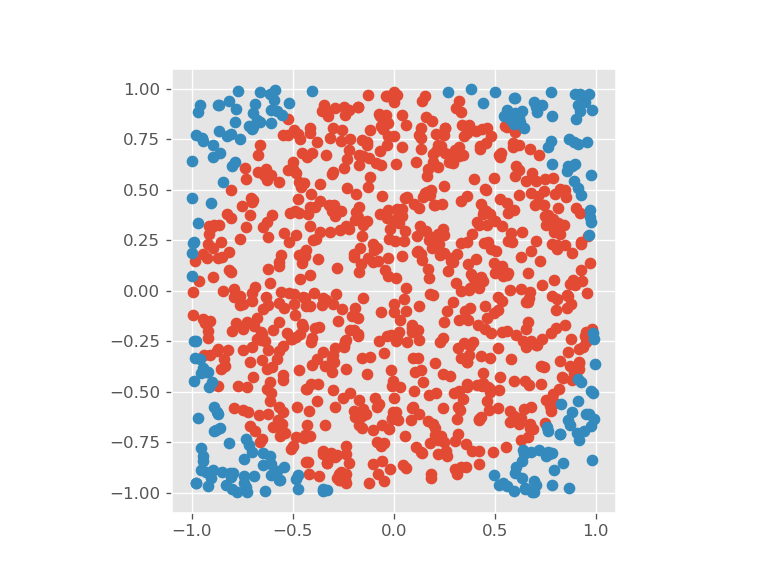

In [21]:
rndm = np.random.RandomState(12345)

N = 1000
x, y = rndm.uniform(low=-1, high=1, size=(2, N))
m = inside(x, y, 1)

fig, ax = plt.subplots()
ax.plot(x[m], y[m], 'o')
ax.plot(x[~m], y[~m], 'o')
ax.set_aspect('equal')


In [22]:
# Now, the estimate for the area is

4 * np.count_nonzero(m) / N

3.176

Note that the result comes as a sum of iid samples, so that the Central Limit Theorem says that the error of the estimate scales as $\propto 1 / \sqrt{N}$.

## II. Integrals of arbitrary functions

To generalize the prescription, let's rewrite it in a slightly more general form. Define 

$$
A(\mathbf{r}) = \left\{
\begin{aligned}
1,& \qquad{\mathbf{r} \in \mathcal{C}}\;, \\
0,& \qquad\text{otherwise}\;.
\end{aligned}
\right.
$$

Then the Buffon's needle prescription in $d$ dimensions is

$$
\frac{\int_\mathcal{D} A(\mathbf{r})\, d^d\mathbf{r}}{\Omega_D} \approx \frac{\sum_{j} A(\mathbf{r}_j)}{\sum_j 1} \;.
$$

Here $\mathbf{r}_j$ are $d$-dimensional vectors drawn from a uniform distribution on $\mathcal{D}$, the unit hypercube in $d$ dimensions.

When written in this form, the prescription is clearly valid for arbitrary $d$ and arbitrary functions $A(\mathbf{r})$.

#### Example: calculate

$$
\iint_\limits{x^2 + y^2 < 1}  e^{-(x^2 + y^2)} \, dx\, dy 
$$

Here $\mathcal{C}$ is the inside of a unit circle, $\{(x, y): x^2 + y^2 < 1 \}$, and $A(x, y) = e^{-(x^2+y^2)}$.

(This example is artificially fine-tuned to ease the comparison with an exact answer, which is $\pi (1 - e^{-1}).$)

In [24]:
def func(x, y):
    r2 = x**2 + y**2
    return np.exp(-r2)

In [25]:
def sample(N, r=1):
    N = int(N)
    x, y = rndm.uniform(low=-1, high=1, size=(2, N))
    accepted = inside(x, y, r)
    denom = accepted.sum()
    return np.sum(func(x[accepted], y[accepted]) / N) * 4, denom

In [26]:
answer = np.pi * (1. - 1./np.e)

np.random.seed(12)

for n in [100, 1000, 10000, 100000, 1e6, 1e7]:
    res = sample(n)
    err = res[0] - answer
    print("%8d  %.7g  %.7g %g" % (n, res[0], answer, err))

     100  2.093158  1.985865 0.107292
    1000  2.019979  1.985865 0.0341134
   10000  1.964416  1.985865 -0.0214495
  100000  1.982801  1.985865 -0.00306389
 1000000  1.987293  1.985865 0.00142807
10000000  1.985898  1.985865 3.31245e-05


To improve convergence, we can either aim to sample the space *more* uniformly, or *less* uniformly.

## III. Quasi-random numbers: Sobol, Halton sequences

Instead of drawing random variates, use special *low-discrepancy sequences* which intend to cover the volume in a uniform manner.

Here's one implementation: In terminal, type 

`pip install sobol_seq --user`

In [9]:
#!pip install sobol_seq

In [27]:
import sobol_seq

In [28]:
sobol_seq.i4_sobol_generate?

In [29]:
sobol_seq.i4_sobol_generate(2, 5)

array([[0.5  , 0.5  ],
       [0.75 , 0.25 ],
       [0.25 , 0.75 ],
       [0.375, 0.375],
       [0.875, 0.875]])

<IPython.core.display.Javascript object>


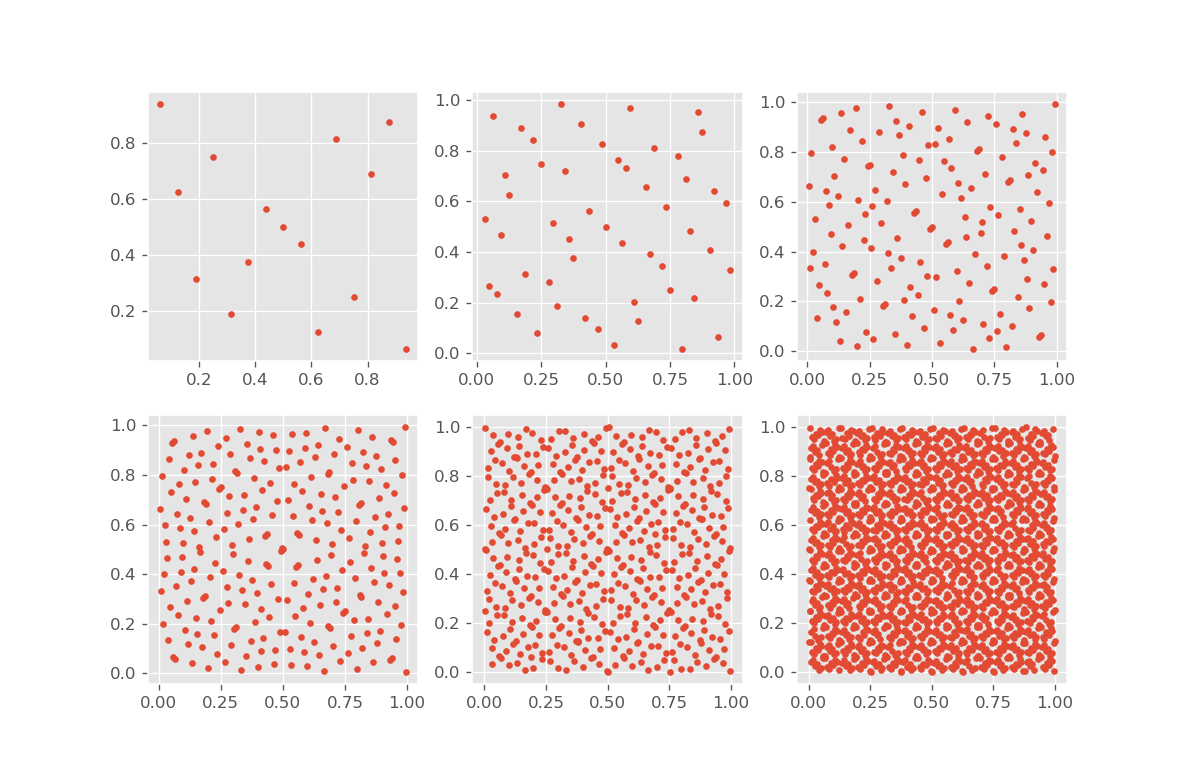

In [31]:
nn = [[15, 51, 151], [251, 521, 2001]]

fig, axx = plt.subplots(2, 3)

for i in (0, 1):
    for j in (0, 1, 2):
        N = nn[i][j]
        ax = axx[i][j]
        x = sobol_seq.i4_sobol_generate(2, N)
        ax.plot(x[:, 0], x[:, 1], 'o', label = "N = %s" % N, ms=4, mec='none')

## IV. Non-uniform distributions

If the integral has sharp peaks, both *Buffon needle II* and quas-random based methods can be converging slowly.
If the integral is over an infinite range, they simply break down. 

Note that in *Buffon needle II*, the integral in the left-hand side contains the *probability density of a uniform distribution on $\mathcal{D}$*

$$
w_\mathrm{uniform}(\mathbf{r}) = \frac{1}{\Omega_D} d^d\mathbf{r}
$$

This suggests introducing a probability density $w(\mathbf{r})$, and rewriting the target integral via

$$
\int_\mathcal{D} A(\mathbf{r})\,d^d\mathbf{r} \equiv
\int_\mathcal{D} \frac{A(\mathbf{r}) }{ w(\mathbf{r})} \,\color{red}{w(\mathbf{r})\, d^d\mathbf{r}} \;.
$$

Now, if the sequence of $\{ \mathbf{r}_j\}$, $j=1, \dots, N$, *is drawn from the distribution $w(\mathbf{r})$*, then

$$
\int_\mathcal{D} A(\mathbf{r})\,d^d\mathbf{r} \approx \frac{\sum_j A(\mathbf{r}_j)\, /\, w(\mathbf{r}_j)}{\sum_j 1}
$$

#### Example

$$
\int_0^\infty \! x^3 e^{-x} \, dx = \text{?}
$$

Here we take $w(x) \propto e^{-x}$ on $x \in [0, \infty)$, and $A(x) = x^3$

In [32]:
for n in (1e4, 1e5, 1e6, 1e7):
    nn = int(n)
    x = np.random.exponential(size=nn)
    res = (x**3).sum() / n
    print("%8g  %.6g" % (nn, res))

   10000  6.12337
  100000  5.97928
   1e+06  6.00973
   1e+07  6.00365


### How to draw variates given a probability density function?

#### Rejection method

This is basically the Buffon's needle again: Given a p.d.f., $w(\mathbf{r})$, for $d$-dimensional variables, draw $d$ uniform variates, $\mathbf{r}$, and an extra one, $y$, uniform on $[0, 1)$. Compare $y$ and $w(\mathbf{r})$. If $y > w(\mathbf{r})/max (w)$, *reject* it and draw again. Otherwise, return $\mathbf{r}$. 

#### Example:
Want random variable with density:
$$
\omega \propto e^{-x^2/2}[sin^2(4+x) +2cos^2(x)sin^2(5x)]
$$
(we ommit the normalization coeffcient)

In [51]:
def w(x):
    return np.exp(-x**2/2)*(np.sin(4+x)**2 +2*np.cos(x)**2 * np.sin(5*x)**2)

<IPython.core.display.Javascript object>


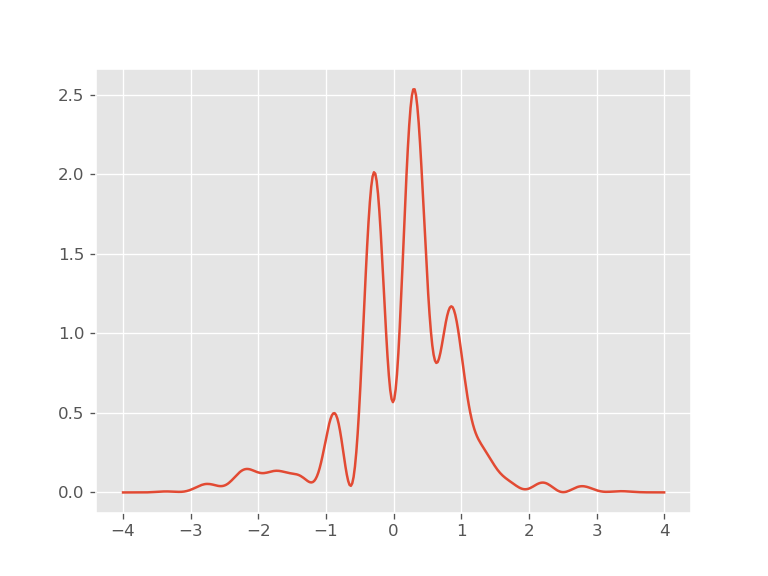

In [75]:
x = np.linspace(-4,4,400)
plt.figure()
plt.plot(x, w(x))
plt.show()

Lets consider only more posible value $X\in[-4,4]$.
Generate the uniform $x$ in this interval:

In [70]:
xr = rndm.uniform(low=-4, high=4, size=1)
xr

array([-1.56186785])

<IPython.core.display.Javascript object>


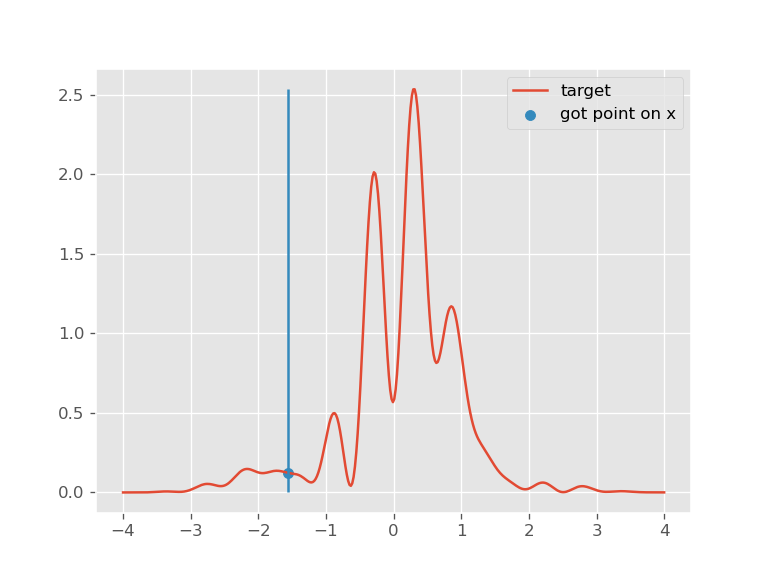

In [79]:
plt.plot(x, w(x), label='target')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.scatter(xr, w(xr), color=colors[1], label=r'got point on x')
plt.vlines(xr, 0, w(x).max(), color=colors[1])
plt.legend()
plt.show()

Generate uniform y on $[0,1]$:

In [82]:
yr = rndm.uniform(0,1,1)
yr

array([0.35229548])

If $y\cdot max(w)<(X)$ --- accept X in set and reject another:

<IPython.core.display.Javascript object>


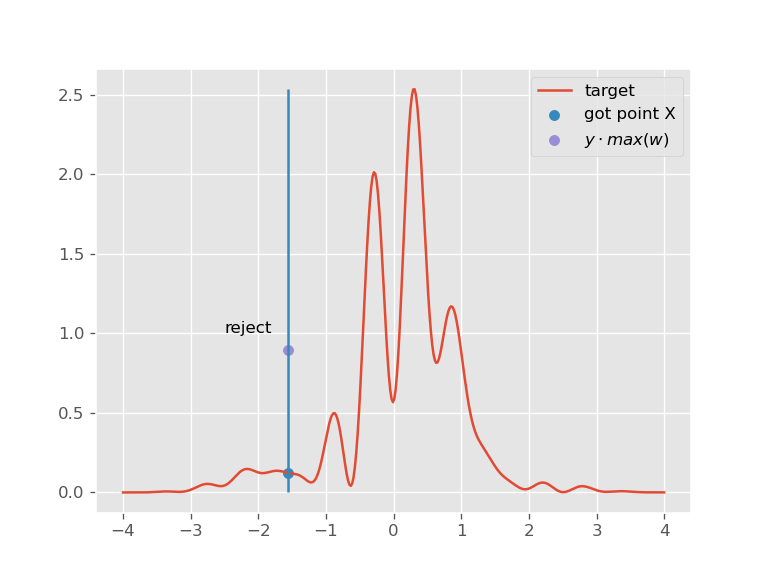

In [91]:
plt.plot(x, w(x), label='target')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.scatter(xr, w(xr), color=colors[1], label=r'got point X')
plt.vlines(xr, 0, w(x).max(), color=colors[1])
plt.scatter(xr, yr*w(x).max(), label=r'$y\cdot max(w)$', color = colors[2])
plt.text(-2.5,1,'accept' if yr*w(x).max()<w(xr) else 'reject')
plt.legend()
plt.show()

Really we should generate the 2-d uniform point in $(X_{min}, X_{max})\times (0, max(w))$
and accept all point under graph $w(x)$:


<IPython.core.display.Javascript object>


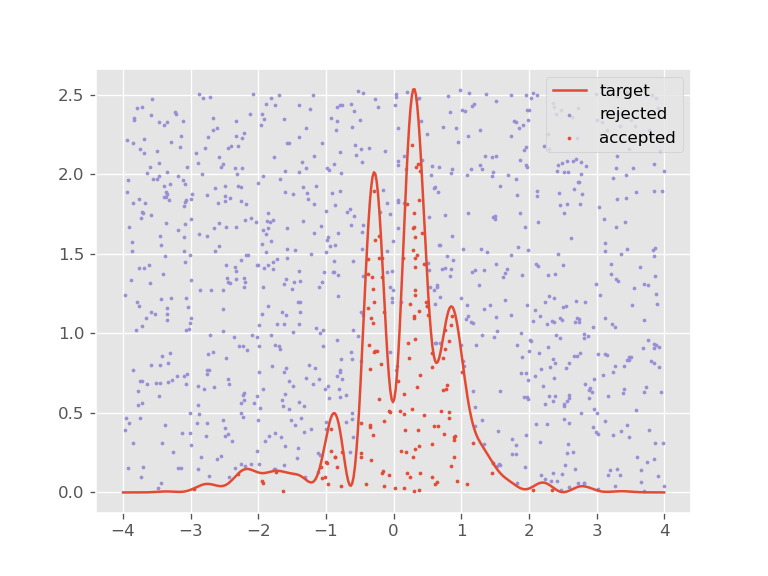

In [104]:
xr = rndm.uniform(low=-4, high=4, size=1000)
yr = rndm.uniform(0,1,1000)
w_max = w(x).max()
accept = (yr*w_max < w(xr))

plt.plot(x, w(x), label='target')

plt.scatter(xr[~accept], yr[~accept]*w_max, s=3, color=colors[2], label='rejected')

plt.scatter(xr[accept], yr[accept]*w_max, s=3, color=colors[0], label='accepted')

plt.legend()
plt.show()

Obviously, distribution $X_{accepted}$ is $\propto w(x)$,
lets check on digramm:

<IPython.core.display.Javascript object>


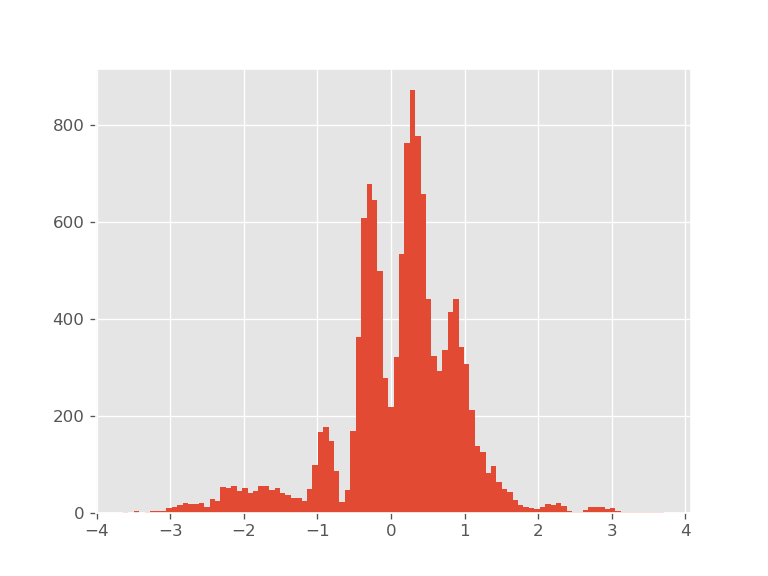

In [107]:
xr = rndm.uniform(low=-4, high=4, size=100000)
yr = rndm.uniform(0,1,100000)
w_max = w(x).max()
accept = (yr*w_max < w(xr))
plt.hist(xr[accept], 100)
plt.show()

One sad thing is we acept a small part of point:

In [109]:
np.sum(accept)/accept.shape[0]

0.12994

We can improve algoritm, by using for $X$ some similar on $w$ but convinent p.d.f. $g(x)$.
Idea:
we should generate uniform point not on the rectangular, but on the area, include nessesary subgraph.

Consider random pair $(X, Z = y\cdot g(X))$ 2-d density (x, z) is uniform on subgraph g (Easy check)

Now we should generate $X$ with $g$ distribution function, and replace accept-criterion with:
$$
y \cdot C < w(X)/g(X), \text{ where }  C = max(w/g) 
$$

Here convinient g is:
    $$
    g\propto e^{-x^2/2}
    $$

<IPython.core.display.Javascript object>


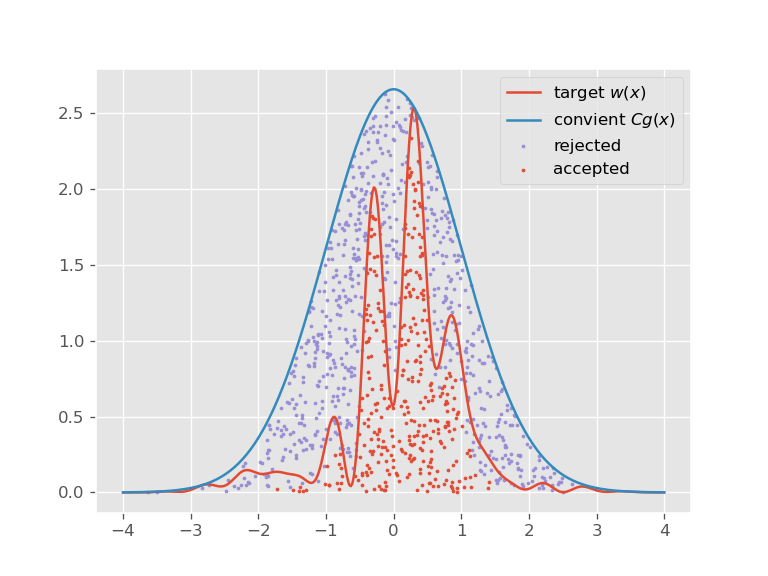

In [125]:
def g(x):
    return np.exp(-x**2/2)
x = np.linspace(-4,4,400)
C = (w(x)/g(x)).max()
plt.figure()
plt.plot(x, w(x), label=r'target $w(x)$')
plt.plot(x, g(x)*C, label='convient $C g(x)$')








xr = rndm.normal(0, 1, size=1000)
yr = rndm.uniform(0,1,1000)
accept = (yr*C < w(xr))


plt.scatter(xr[~accept], yr[~accept]*C*g(xr[~accept]), s=3, color=colors[2], label='rejected')

plt.scatter(xr[accept], yr[accept]*C*g(xr[accept]), s=3, color=colors[0], label='accepted')

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


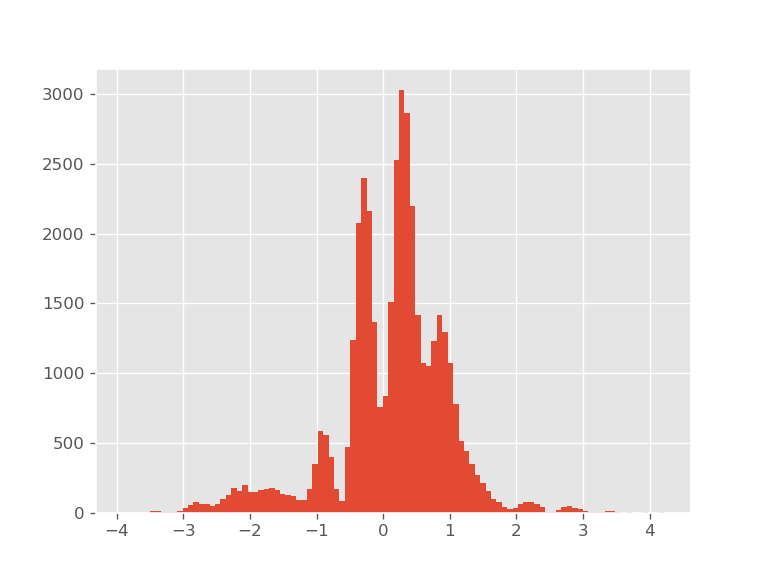

In [119]:
xr = rndm.normal(0, 1, size=100000)
yr = rndm.uniform(0,1,100000)
accept = (yr*C < w(xr)/g(xr))
plt.hist(xr[accept], 100)
plt.show()

In [120]:
np.sum(accept)/accept.shape[0]

0.40558

More details in 
https://en.wikipedia.org/wiki/Rejection_sampling

#### Inversion method ($d=1$)

Draw $r$ uniform on  $[0, 1)$. Then invert the cumulative distribution function, `cdf`: find $x$ such that 

$$
\mathrm{cdf}(x) = r\;.
$$ 


##### Example

Draw variates from the standard exponential distribution $w(x) \propto \exp(-\lambda x)$ for $x \in [0, \infty)$.

Doing the integrals, we find

$$
\mathrm{cdf}(x) = A \int_0^x\! e^{-\lambda x }\, dx = A \frac{1 - e^{-\lambda x}}{\lambda} \;,
$$

where $A$ is the normalization constant, for which we find $A = \lambda$ since $\mathrm{cdf}(\infty) = 1$.

This way, we find 

$$
x = -\frac{1}{\lambda} \ln(1 - r) \;.
$$

Note that, strictly speaking, we cannot replace $1 - r$ by $r$ since that would be problematic at $r=0$.

<IPython.core.display.Javascript object>


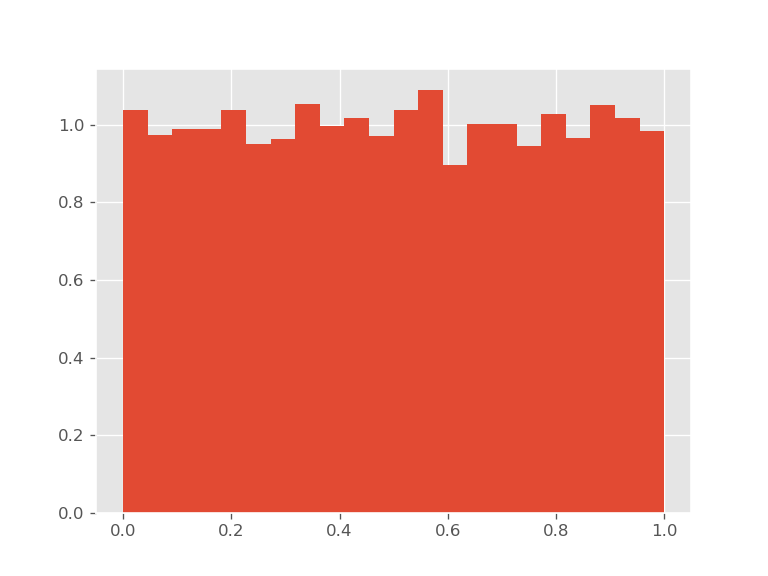

(array([1.03868202, 0.9748647 , 0.98806828, 0.99026888, 1.03868202,
        0.95065812, 0.96386171, 1.05408621, 0.99687067, 1.01887665,
        0.9704635 , 1.03868202, 1.08929577, 0.89564319, 1.00127187,
        1.00127187, 0.94625693, 1.02767904, 0.96606231, 1.05188561,
        1.01887665, 0.98366709]),
 array([2.41110643e-05, 4.54663147e-02, 9.09085183e-02, 1.36350722e-01,
        1.81792925e-01, 2.27235129e-01, 2.72677333e-01, 3.18119536e-01,
        3.63561740e-01, 4.09003943e-01, 4.54446147e-01, 4.99888351e-01,
        5.45330554e-01, 5.90772758e-01, 6.36214961e-01, 6.81657165e-01,
        7.27099369e-01, 7.72541572e-01, 8.17983776e-01, 8.63425979e-01,
        9.08868183e-01, 9.54310387e-01, 9.99752590e-01]),
 <BarContainer object of 22 artists>)

In [37]:
r = np.random.uniform(size=10000)
plt.hist(r, bins='auto', density=True)

<IPython.core.display.Javascript object>


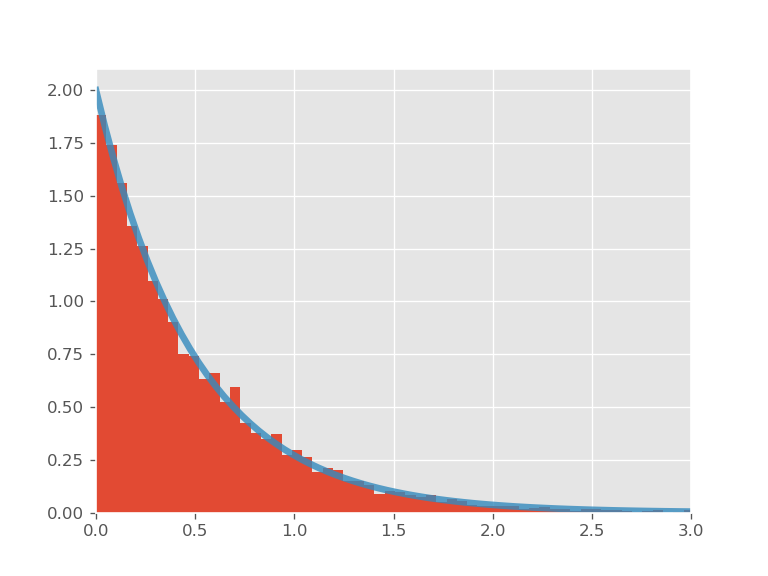

(0.0, 3.0)

In [36]:
x = -0.5 * np.log(1 - r)
plt.hist(x, bins='auto', density=True)

xx = np.linspace(x.min(), x.max(), 101)
plt.plot(xx, 2.0 * np.exp(-2*xx), '-', lw=4, alpha=0.8)

plt.xlim([0, 3])

# Excercises

1. Implement integration over a rectangular domain with a double Legendre quadrature.
2. Implement integration over a trangular domain with a mixed Legendre/Jacobi quadrature. 

3. Repeat the Buffon's needle experiment for a range of $N$. Study the convergence of the result to the correct answer. Compare your findings to the CLT prediction, the $\sqrt{N}$ dependence.

4. Generalize the Buffon's needle experiment to $d$ dimensions to compute the volume of a $d$-dimensional hypersphere.

5. Use the Sobol sequence to calculate the value of
$$
\iint\limits_D e^{-(x^2 + y^2)} \, dx\, dy  \;,
$$
where $D$ is the unit square. Compare to the exact answer (which can be expressed in terms of the error function).

6. Generate variates from the distribution $w(x) \propto \sqrt{1 - x^2}$ on $x\in (-1, 1)$ using the rejection method.

7. Generate variates from the distribution $w(x) \propto \exp(-\lambda x)$ on $x \in [a, b]$.